<a href="https://colab.research.google.com/github/LuciaHrovatin/Insurance-Claim-Prediction/blob/main/InsuranceClaimPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Insurance Claim Prediction
## Project 2
### CAS Introduction to Machine Learning in Finance and Insurance (Spring 2025)
#### Navarro Diego - <href>dnavarro@ethz.ch</href>
#### Rizzi Michele - <href>mirizzi@ethz.ch</href>
#### Hrovatin Lucia - <href>lhrovatin@ethz.ch</href>

</center>

## Initial Setup

In [ ]:
# Import all the Python libraries we are going to use

## Data Cleansing and Manipulation
import numpy as np
import pandas as pd

## Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Statistical learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV

## Deep Learning - TensorFlow and Keras
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow --quiet
    import tensorflow as tf

try:
    import keras
except ImportError:
    !pip install keras --quiet
    import keras

try:
    import keras_tuner as kt
except ImportError:
    !pip install keras-tuner --quiet
    import keras_tuner as kt

In [ ]:
# Fix random seed for reproducibility
random_seed = 43
np.random.seed(random_seed)

## Exercise 1: EDA - Exploratory Data Analysis

### 1.1. Data load and feature calculation

In [ ]:
# Read csv file saved in the same directory
df = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',')

# Compute frequency as per project requirements
df['freq'] = df['ClaimNb'] / df['Exposure']

### 1.2 Descriptive Statistics

In [ ]:
# Descriptive statistics
desc = df.describe(include='all').T
medians = df.median(numeric_only=True)

# Add median to the summary table
desc['median'] = medians

# Add a column with the data format (dtype) for each feature
desc['dtype'] = df.dtypes

# Show formatted table
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,median,dtype
VehPower,678007.0,NaN,NaN,NaN,6.454653,2.050902,4.0,5.0,6.0,7.0,15.0,6.00,int64
VehAge,678007.0,NaN,NaN,NaN,7.044218,5.666235,0.0,2.0,6.0,11.0,100.0,6.00,int64
DrivAge,678007.0,NaN,NaN,NaN,45.499061,14.137492,18.0,34.0,44.0,55.0,100.0,44.00,int64
BonusMalus,678007.0,NaN,NaN,NaN,59.761588,15.6367,50.0,50.0,50.0,64.0,230.0,50.00,int64
VehBrand,678007,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
VehGas,678007,2,Regular,345871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
Density,678007.0,NaN,NaN,NaN,1792.430975,3958.663031,1.0,92.0,393.0,1658.0,27000.0,393.00,int64
Region,678007,22,R24,160601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
Exposure,678007.0,NaN,NaN,NaN,0.528547,0.364081,0.002732,0.18,0.49,0.99,1.0,0.49,float64
ClaimNb,678007.0,NaN,NaN,NaN,0.038913,0.204752,0.0,0.0,0.0,0.0,5.0,0.00,int64


### 1.3 Exploratory visualizations

Average Frequency = 0.0736
Fraction of exposure with zero claims = 95.2%


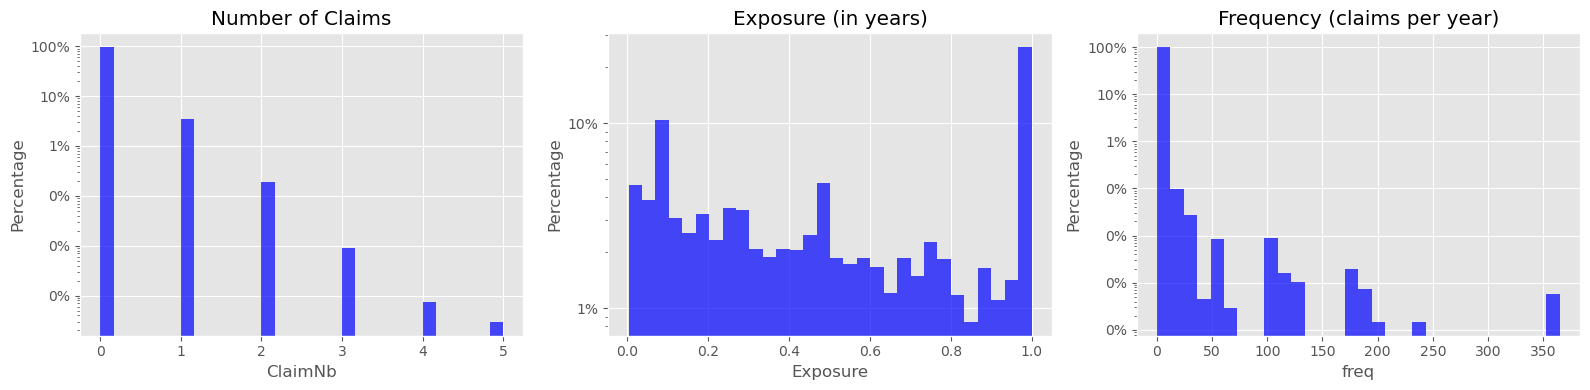

In [ ]:
# Print summary statistics for average frequency and number of cases with zero-claim
print(
    "Average Frequency = {0:.3}".format(np.average(df["freq"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

# Plot histograms with percentages
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))

def plot_percent_hist(data, ax, title, bins=30):
    """Plot a histrogram with percentages with respect to the total number of samples.
    Params:
        data: Pandas Series containing the data to plot.
        ax: Axes object to plot on.
        title: Title for the plot.
        bins: Number of bins for the histogram. Defaults to 30.

    """
    # Plot as histogram
    ax.hist(data, bins=bins, density=False, log=True, weights=np.ones(len(data)) / len(data), color='blue', alpha=0.7)
    ax.set_title(title)
    ax.set_ylabel("Percentage")
    ax.set_xlabel(data.name)
    ax.yaxis.set_major_formatter(lambda y, _: '{:.0%}'.format(y))

# Plot each histogram
plot_percent_hist(df["ClaimNb"], ax0, "Number of Claims")
plot_percent_hist(df["Exposure"], ax1, "Exposure (in years)")
plot_percent_hist(df["freq"], ax2, "Frequency (claims per year)")

plt.tight_layout()
plt.show()

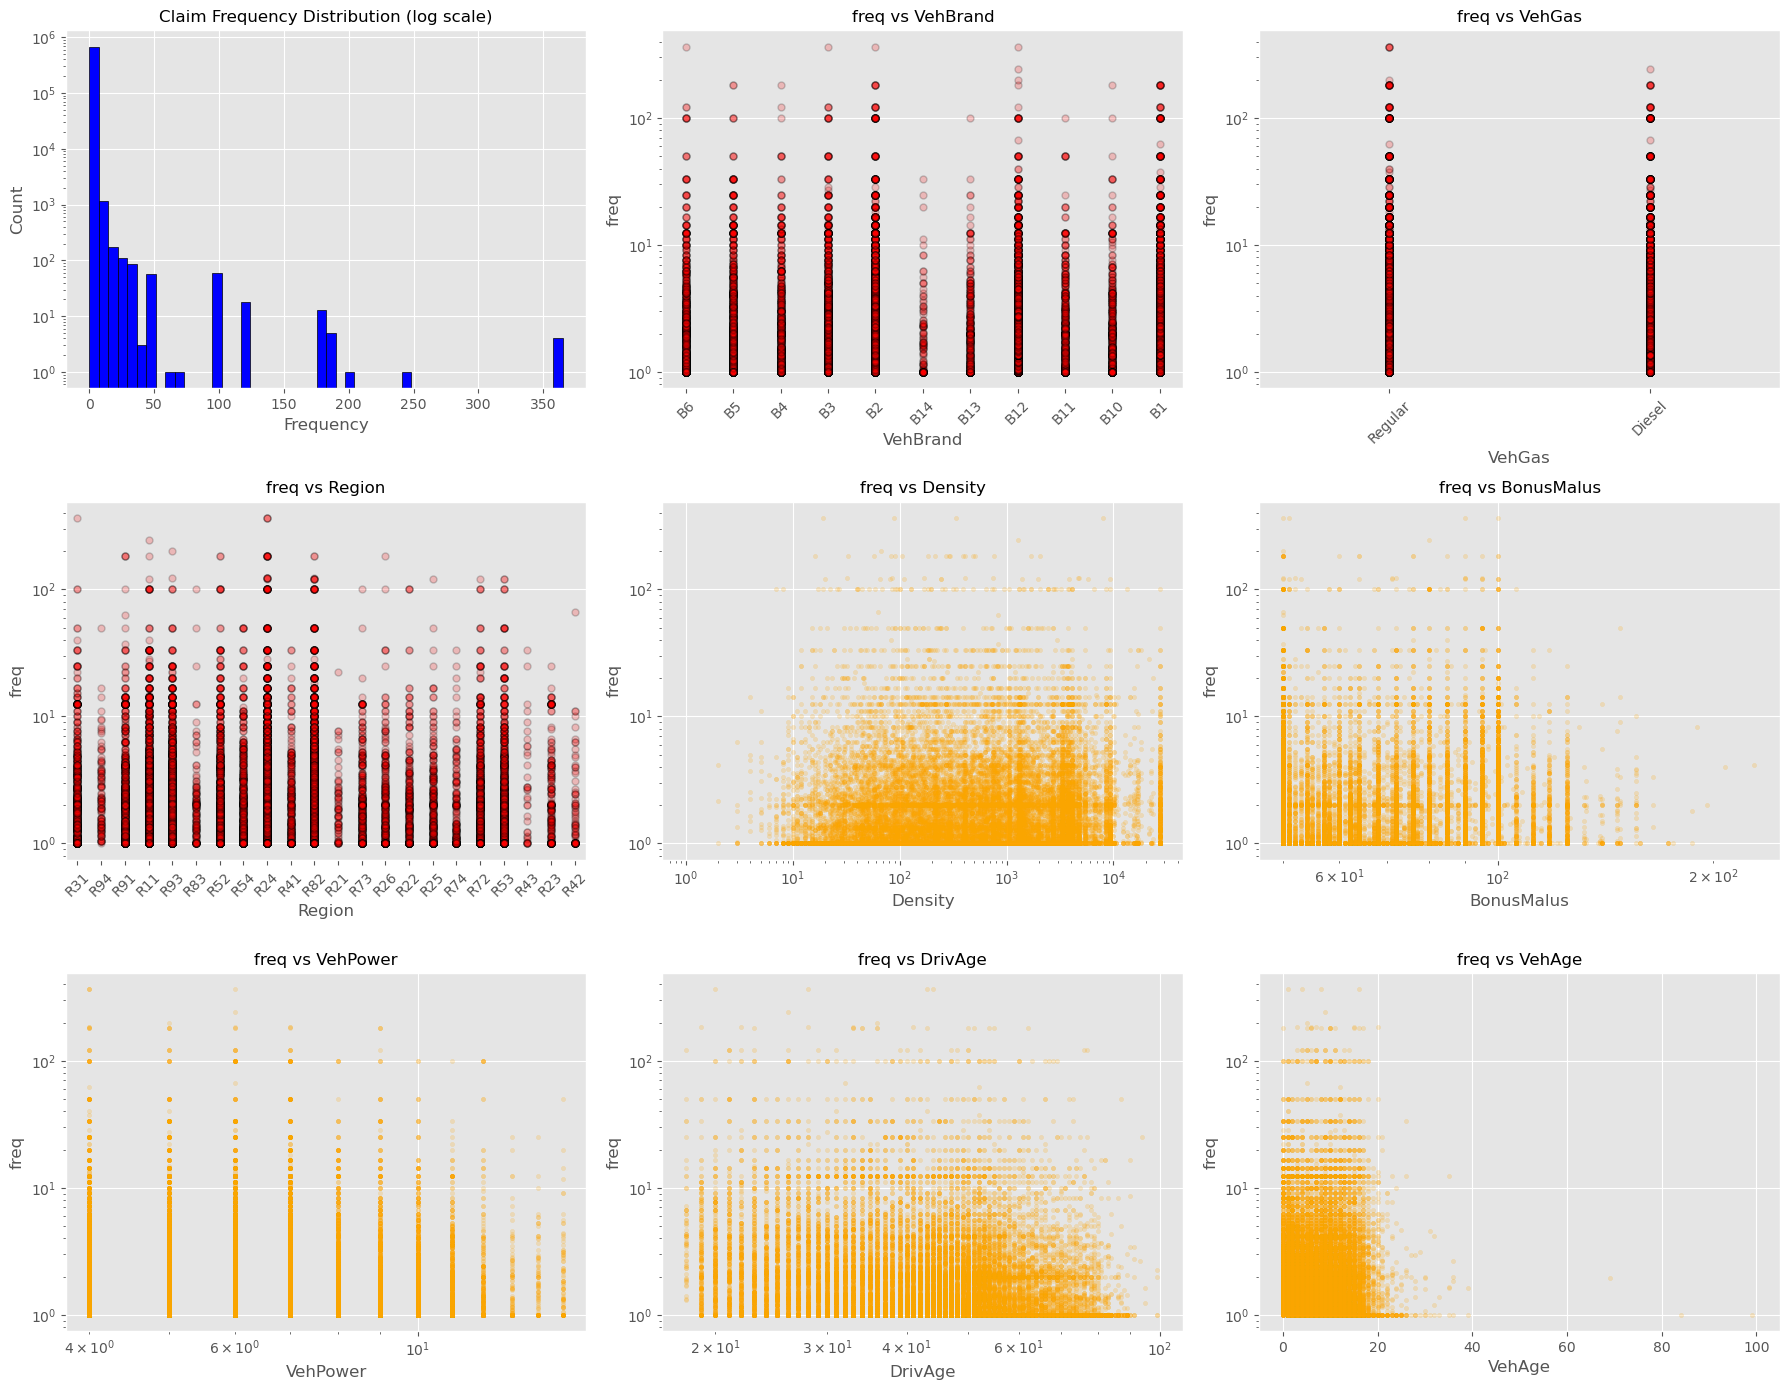

In [ ]:
# Print visual analysis for all features vs Frequency
plt.style.use('ggplot')
color_hist = 'blue'
color_box = 'red'
color_scatter = 'orange'

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

# Histogram of freq
ax = axes[0]
df['freq'].hist(bins=50, ax=ax, color=color_hist, edgecolor='black')
ax.set_yscale('log')
ax.set_title('Claim Frequency Distribution (log scale)', fontsize=12)
ax.set_xlabel('Frequency')
ax.set_ylabel('Count')

# Boxplots for categorical features
groups = ['VehBrand', 'VehGas', 'Region']
for idx, col in enumerate(groups, start=1):
    ax = axes[idx]
    sns.boxplot(x=col, y='freq', data=df, ax=ax, color=color_box,
                flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor=None, alpha = 0.2))
    ax.set_yscale('log')
    ax.set_title(f'freq vs {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.tick_params(axis='x', rotation=45)

# Scatter plots for continuous variables
conts = ['Density', 'BonusMalus', 'VehPower', 'DrivAge', 'VehAge']
for idx, col in enumerate(conts, start=4):
    ax = axes[idx]
    sns.scatterplot(x=df[col], y=df['freq'], ax=ax, color=color_scatter, alpha=0.2, edgecolor=None, s=10)
    if df[col].min() > 0:
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(col)
    ax.set_ylabel('freq')
    ax.set_title(f'freq vs {col}', fontsize=12)

# Hide any unused subplot axes
for j in range(len(groups) + len(conts) + 1, len(axes)):
    axes[j].set_visible(False)

fig.tight_layout()
plt.show()

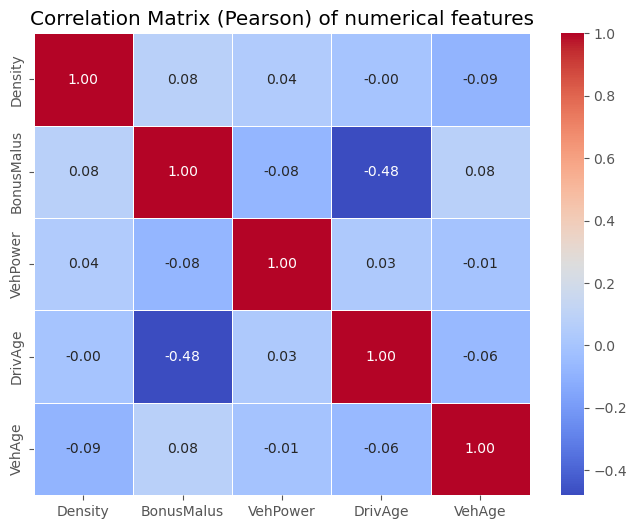

In [ ]:
# Multicollinearity check on numeric features

# Compute Pearson correlation matrix
corr_matrix = df[conts].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Pearson) of numerical features")
plt.show()

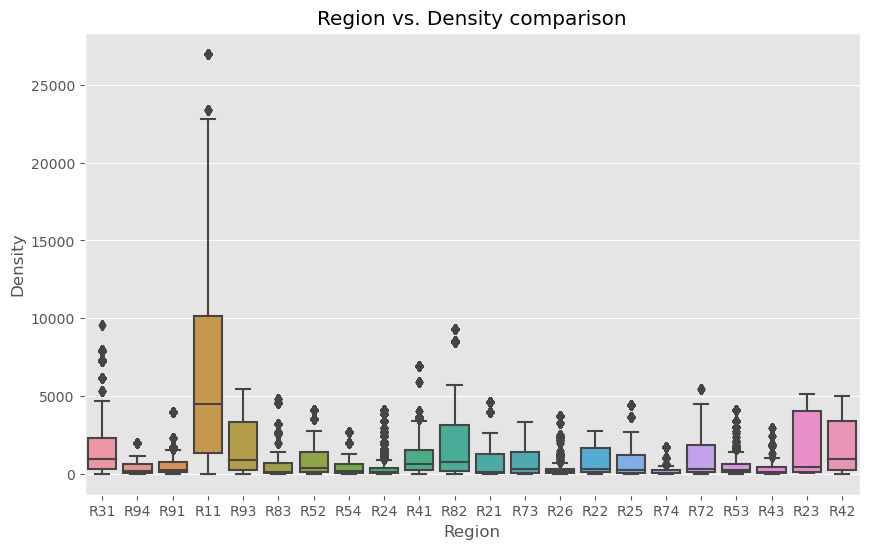

In [ ]:
# Hypothesis: Population density and Region might be related.

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Region", y="Density", data=df)
plt.title('Region vs. Density comparison')
plt.ylabel('Density')
plt.xlabel('Region')
plt.show()



### 1.4 Feature Engineering (1)

In [ ]:
# Bin VehAge as per project requirements
df['VehAge_bin'] = pd.cut(df['VehAge'], bins=[0,6,13,np.inf], labels=['0-5','6-12','13+'])

# Log transforms as per project requirements and limit skewness
df['ln_VehPower'] = np.log(df['VehPower'])
df['ln_DrivAge']  = np.log(df['DrivAge'])
df['ln_BM']       = np.log(df['BonusMalus'])
df['ln_Density']  = np.log(df['Density'])

### 1.5 Train-Test Split

In [ ]:
# Define features and sample weights
y = df['freq'] # Target variable: frequency of claims
sample_weight = df['Exposure'] # Sample weights: exposure time in years as per Poisson Deviance loss function

# Specify numeric and categorical features for preprocessing (2)
numeric_features = ['ln_VehPower','ln_DrivAge','ln_BM','ln_Density']
categorical_features = ['VehBrand','VehGas','Region','VehAge_bin']

# Test (90%) and Train (10%) split
X = df[numeric_features + categorical_features]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weight, test_size=0.1, random_state=random_seed
)

## Exercise 2: Feature Engineering (2) and Poisson GLM

In [ ]:
# Create a preprocessing flexible pipeline with StandardScaler for numeric features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
])

# Create a Poisson regression model with the preprocessor and fit it to the training data
glm = Pipeline(steps=[
    ('pre', preprocessor),
    ('glm', PoissonRegressor(alpha=0.0, max_iter=1000))
])
glm.fit(X_train, y_train, glm__sample_weight=w_train)

# Predict on training and test sets
y_pred_train = glm.predict(X_train)
y_pred_test  = glm.predict(X_test)

## Exercise 3: Poisson GLM with Interaction Features

### 3.1 Set up GLM and Interaction features

In [ ]:
def add_interactions(X_df,df):
    """
    This function adds interaction features based on project requirements.
    Interaction features include:
    - DrivAge squared
    - BonusMalus multiplied by DrivAge
    - BonusMalus multiplied by DrivAge squared
    Params:
        X_df: DataFrame containing the features for which interactions are to be added.
        df: Original DataFrame containing the 'DrivAge' and 'BonusMalus' columns.
    """
    df_int = X_df.copy()
    df_int['DrivAge2'] = df['DrivAge']**2
    df_int['BMxDA']    = df['BonusMalus'] * df['DrivAge']
    df_int['BMxDA2']   = df['BonusMalus'] * df_int['DrivAge2']
    return df_int

# Add interaction features on train and test sets
X_train_int = add_interactions(X_train,df)
X_test_int  = add_interactions(X_test,df)

# Specify the new numeric features list including interaction terms
numeric_int = numeric_features + ['DrivAge2','BMxDA','BMxDA2']

# Same preprocessor of GLM but with interaction terms
preprocessor_int = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_int),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
])

# GLM with interaction terms
glm_int = Pipeline(steps=[
    ('pre', preprocessor_int),
    ('glm', PoissonRegressor(alpha=0.0, max_iter=1000))
])
glm_int.fit(X_train_int, y_train, glm__sample_weight=w_train)

# Predict on training and test sets with interaction terms
y_pred_int_train = glm_int.predict(X_train_int)
y_pred_int_test = glm_int.predict(X_test_int)

### 3.2 Evaluate results, comparing GLM vs GLM+Int

In [ ]:
# Define the weighted metrics functions from sklearn and our custom Poisson deviance function
def weighted_mae(y, y_pred, w):
    return mean_absolute_error(y, y_pred, sample_weight=w)

def weighted_mse(y, y_pred, w):
    return mean_squared_error(y, y_pred, sample_weight=w)

def poisson_deviance(y, y_pred, w):
    """
    Compute the Poisson deviance for the given true values and predictions.
    The Poisson deviance is a measure of how well the predicted values fit the true values
    under the assumption that the data follows a Poisson distribution.
    Even if there is the sklearn function available, we implement our own version.

    Params:
        y: True values (observed counts).
        y_pred: Predicted values (expected counts).
        w: Sample weights for each observation.
    """
    return 2*np.sum(w * (y * np.log((y + 1e-8)/y_pred) - (y - y_pred)))/ np.sum(w)

# GLM metrics
mae_train = weighted_mae(y_train, y_pred_train, w_train)
mse_train = weighted_mse(y_train, y_pred_train, w_train)
mae_test  = weighted_mae(y_test, y_pred_test, w_test)
mse_test  = weighted_mse(y_test, y_pred_test, w_test)
deviance_train = poisson_deviance(y_train, y_pred_train, w_train)
deviance_test  = poisson_deviance(y_test,  y_pred_test,  w_test)

# GLM with Interaction metrics
mae_int_train = weighted_mae(y_train, y_pred_int_train, w_train)
mse_int_train = weighted_mse(y_train, y_pred_int_train, w_train)
mae_int_test  = weighted_mae(y_test, y_pred_int_test, w_test)
mse_int_test  = weighted_mse(y_test, y_pred_int_test, w_test)
deviance_int_train = poisson_deviance(y_train, y_pred_int_train, w_train)
deviance_int_test  = poisson_deviance(y_test,  y_pred_int_test,  w_test)

# Comparison DataFrame
df_compare = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [round(mae_train, 4), round(mse_train, 4), round(deviance_train, 4)],
    'GLM Test':    [round(mae_test, 4), round(mse_test, 4), round(deviance_test, 4)],
    'GLM+Int Train': [round(mae_int_train, 4), round(mse_int_train, 4), round(deviance_int_train, 4)],
    'GLM+Int Test':  [round(mae_int_test, 4), round(mse_int_test, 4), round(deviance_int_test, 4)],
})
df_compare.T

,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.138,0.233,0.456
GLM Test,0.139,0.273,0.467
GLM+Int Train,0.138,0.233,0.456
GLM+Int Test,0.139,0.273,0.467


## Exercise 4. Poisson Feedforward Neural Network (FNN)

### 3.1 Define Model Architecture and Hyperparameter Tuning

In [ ]:
class HyperModelTuned(kt.HyperModel):
    def __init__(self, input_shape,loss= None):
        """
        A KerasTuner HyperModel for tuning a feedforward neural network for regression.

        Params:
        ----------
        input_shape : int
            Number of input features.
        loss : str or None, optional
            Loss function to use. Allowed values: 'poisson', 'mean_squared_error'. If None, defaults to 'poisson'.
        """
        self.loss = loss
        super().__init__()
        self.input_shape = input_shape

    def build(self, hp):
        """
        Build a Keras model with hyperparameters defined by the KerasTuner HyperModel.
        Params:
        ----------
        hp : kt.HyperParameters
            Hyperparameters to be tuned are:
            - Number of layers
            - Number of units in each layer
            - Activation function (ReLU or Leaky ReLU)
            - Dropout rate
            - Learning rate
        Returns:
        ----------
        model : compiled Keras model ready for training.
        """
        model = keras.Sequential()
        # Input layer with the specified input shape
        model.add(keras.layers.Input(shape=(self.input_shape,)))

        # Activation function choice
        hp_activation_fnc = hp.Choice('activation_type', values=['relu', 'leaky_relu'])

        # Tune depth and width of the (fully connected) network
        for i in range(hp.Int('num_layers', 2, 4)): # number of hidden layers
            model.add(keras.layers.Dense(
                units=hp.Int(f'units_layer_{i}', min_value=15, max_value=25, step=5), # number of units in each layer
                activation=None, # activation function set to none to perform batch normalization
                bias_initializer='zeros',
                kernel_initializer="he_normal")) #  He initialization to align with ReLU and variants
            model.add(keras.layers.BatchNormalization()) # batch normalization after each Dense layer

            # Activation function
            if hp_activation_fnc == 'relu':
                model.add(keras.layers.ReLU())
            else:
                model.add(keras.layers.LeakyReLU())

            # Output layer with dropout rate to be tuned
            model.add(keras.layers.Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

        # Exponential output layer as per project requirements
        model.add(keras.layers.Dense(1, activation='exponential'))

        hp_learning_rate = hp.Choice('learning_rate',
                                    values=[1e-2, 1e-3, 1e-4]
                                    )
        # Loss function choice
        if self.loss == 'mean_squared_error':
            loss_fn = keras.losses.MeanSquaredError()
        else:
            loss_fn = keras.losses.Poisson()

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), #  Adam optimizer with a learning rate to be tuned
            loss=loss_fn
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        """
        Fit the Keras model with hyperparameters defined by the KerasTuner HyperModel.
        Params:
        ----------
        hp : Hyperparameters to be tuned are:
            - Batch size
        model : The Keras model to be trained.
        *args: Additional positional arguments to be passed to the model's fit method.
        **kwargs: Additional keyword arguments to be passed to the model's fit method.
        Returns:
        ----------
        model : The trained Keras model.
        """
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [5000, 10000, 15000]),
            **kwargs,
        )

def tuner_build_model_cv(training_set_x, training_set_y, sample_weight, path, name, e, random_seed, input_shape, k=5, loss='poisson'):
    """
    Perform k-fold cross-validation to tune hyperparameters of a Keras model using KerasTuner.
    Params:
    ----------
    training_set_x : Input features for training.
    training_set_y : Target variable for training.
    sample_weight : Sample weights for each observation.
    path : Directory path where the tuner will save its results.
    name : Name of the project for the tuner.
    e : Number of epochs to train each model.
    random_seed : Random seed for reproducibility.
    input_shape : Number of input features.
    k : Number of folds for cross-validation. Defaults to 5.
    loss : Loss function to use. Allowed values: 'poisson', 'mean_squared_error'. Defaults to 'poisson'.
    Returns:
    ----------
    best_tuner : kt.Tuner
        The best tuner from all folds based on validation loss.
    """
    kfold = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    all_val_losses = []

    # Save the best tuner from all folds
    best_tuner = None
    best_loss = float('inf')

    fold = 1
    for train_index, val_index in kfold.split(training_set_x):
        print(f"\n--- Fold {fold} ---")

        x_train, x_val = training_set_x[train_index], training_set_x[val_index]
        y_train, y_val = training_set_y[train_index], training_set_y[val_index]
        sw_train, sw_val = sample_weight[train_index], sample_weight[val_index]

        tuner = kt.RandomSearch(
            HyperModelTuned(input_shape=input_shape, loss=loss),
            objective='val_loss',
            max_trials=5,
            executions_per_trial=1,
            seed=random_seed,
            directory=path,
            project_name=f"{name}_fold{fold}"
        )

        # Introduce early stopping to prevent overfitting and speed up the search
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        tuner.search(
            x_train, y_train,
            sample_weight=sw_train,
            epochs=e,
            validation_data=(x_val, y_val, sw_val),
            callbacks=[stop_early]
        )

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.hypermodel.build(best_hp)
        best_model.fit(
            x_train, y_train,
            sample_weight=sw_train,
            epochs=e,
            validation_split=0.1,
            callbacks=[stop_early]
        )

        val_loss = best_model.evaluate(x_val, y_val, sample_weight=sw_val, verbose=0)
        all_val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_tuner = tuner

        fold += 1

    print(f"\nAverage validation loss over {k} folds: {np.mean(all_val_losses)}")
    return best_tuner

### 4.2 Pre-Process Data and Initialize Hyperparameters

In [ ]:
# Preprocess the neural network input data using the preprocessor defined earlier
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn  = preprocessor.transform(X_test)

# Specify input shape and number of epochs for the neural network
input_shape = X_train_nn.shape[1]
epochs = 100

### 4.3 Hyperparameter Search and Model Creation for MSE loss


In [ ]:
# To test the Poisson assumption, we search for the optimal model using MSE loss to compare with Poisson FNN.
tuner_nn = tuner_build_model_cv(X_train_nn,
                                     y_train.values,
                                     w_train.values,
                                     path='tuner_result',
                                     name='modeling_tuned_benchmark',
                                     random_seed=random_seed,
                                     e=epochs,
                                     input_shape=input_shape,
                                     k=5,
                                     loss='mean_squared_error'
                                     )


--- Fold 1 ---
Reloading Tuner from tuner_result/modeling_tuned_benchmark_fold1/tuner0.json
Epoch 1/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 15s 978us/step - loss: 0.1413 - val_loss: 0.1303
Epoch 2/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 884us/step - loss: 0.1286 - val_loss: 0.1303
Epoch 3/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.1285 - val_loss: 0.1302
Epoch 4/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 13s 959us/step - loss: 0.1285 - val_loss: 0.1302
Epoch 5/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.1285 - val_loss: 0.1302
Epoch 6/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 13s 913us/step - loss: 0.1285 - val_loss: 0.1301
Epoch 7/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.1285 - val_loss: 0.1302
Epoch 8/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 11s 835us/step - loss: 0.1285 - val_loss: 0.1301
Epoch 9/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 859us/step - loss: 0.1285 - val_loss: 0.1301
Epoch 10/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 11s 807us/step - loss

In [ ]:
# Build the MSE FNN benchmark model
nn_benchmark = tuner_nn.hypermodel.build(tuner_nn.get_best_hyperparameters(num_trials=1)[0])

In [ ]:
# Understand the architecture of the benchmark model
nn_benchmark.summary()

best_hp_benchmark = tuner_nn.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters (Poisson Loss):")
for k, v in best_hp_poisson.values.items():
    print(f"{k}: {v}")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 25)             │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821 (7.11 KB)

 Trainable params: 1,731 (6.76 KB)

 Non-trainable params: 90 (360.00 B)


Best hyperparameters (Poisson Loss):
activation_type: relu
num_layers: 2
units_layer_0: 25
dropout_rate: 0.5
units_layer_1: 20
learning_rate: 0.01
units_layer_2: 15
batch_size: 15000
units_layer_3: 25


### 4.4 Hyperparameter Search and Model Creation for Poisson loss

In [ ]:
# Search for the optimal model using Poisson loss as per project requirements
tuner_poisson = tuner_build_model_cv(X_train_nn,
                                     y_train.values,
                                     w_train.values,
                                     path='tuner_result',
                                     name='modeling_tuned_poisson',
                                     random_seed=random_seed,
                                     e=epochs,
                                     input_shape=input_shape,
                                     k=5,
                                     loss='poisson'
                                     )


--- Fold 1 ---
Reloading Tuner from tuner_result/modeling_tuned_poisson_fold1/tuner0.json
Epoch 1/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.1503 - val_loss: 0.1394
Epoch 2/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 850us/step - loss: 0.1370 - val_loss: 0.1385
Epoch 3/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 901us/step - loss: 0.1366 - val_loss: 0.1393
Epoch 4/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 891us/step - loss: 0.1368 - val_loss: 0.1390
Epoch 5/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 13s 917us/step - loss: 0.1368 - val_loss: 0.1387
Epoch 6/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.1367 - val_loss: 0.1383
Epoch 7/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 13s 950us/step - loss: 0.1365 - val_loss: 0.1392
Epoch 8/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 13s 948us/step - loss: 0.1365 - val_loss: 0.1391
Epoch 9/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 838us/step - loss: 0.1365 - val_loss: 0.1387
Epoch 10/100
13730/13730 ━━━━━━━━━━━━━━━━━━━━ 12s 869us/step - loss

In [ ]:
# Build the Poisson FNN model
nn_poisson = tuner_poisson.hypermodel.build(tuner_poisson.get_best_hyperparameters(num_trials=1)[0])

In [ ]:
# Show Poisson FNN model architecture summary and best hyperparameters
nn_poisson.summary()

best_hp_poisson = tuner_poisson.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters (Poisson Loss):")
for k, v in best_hp_poisson.values.items():
    print(f"{k}: {v}")

nn_poisson_batch_size = best_hp_poisson.get('batch_size')

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_37 (Dense)                │ (None, 25)             │         1,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 20)             │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821 (7.11 KB)

 Trainable params: 1,731 (6.76 KB)

 Non-trainable params: 90 (360.00 B)


Best hyperparameters (Poisson Loss):
activation_type: relu
num_layers: 2
units_layer_0: 25
dropout_rate: 0.5
units_layer_1: 20
learning_rate: 0.01
units_layer_2: 15
batch_size: 15000
units_layer_3: 25


In [ ]:
# Train the Poisson FNN model (on 500 epochs) with early stopping to avoid overfitting
stop_early_poisson = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history_poisson = nn_poisson.fit(
    X_train_nn, y_train,
    sample_weight=w_train,
    epochs=500,
    batch_size=nn_poisson_batch_size,
    callbacks=[stop_early_poisson],
    validation_split=0.1,
    verbose=2
)

Epoch 1/500
37/37 - 2s - 52ms/step - loss: 0.4622 - val_loss: 0.1672
Epoch 2/500
37/37 - 1s - 19ms/step - loss: 0.1858 - val_loss: 0.1522
Epoch 3/500
37/37 - 1s - 14ms/step - loss: 0.1745 - val_loss: 0.1464
Epoch 4/500
37/37 - 1s - 17ms/step - loss: 0.1685 - val_loss: 0.1445
Epoch 5/500
37/37 - 0s - 12ms/step - loss: 0.1631 - val_loss: 0.1427
Epoch 6/500
37/37 - 1s - 15ms/step - loss: 0.1599 - val_loss: 0.1421
Epoch 7/500
37/37 - 0s - 13ms/step - loss: 0.1569 - val_loss: 0.1418
Epoch 8/500
37/37 - 1s - 15ms/step - loss: 0.1545 - val_loss: 0.1410
Epoch 9/500
37/37 - 0s - 13ms/step - loss: 0.1526 - val_loss: 0.1408
Epoch 10/500
37/37 - 1s - 21ms/step - loss: 0.1511 - val_loss: 0.1403
Epoch 11/500
37/37 - 1s - 23ms/step - loss: 0.1494 - val_loss: 0.1403
Epoch 12/500
37/37 - 0s - 13ms/step - loss: 0.1487 - val_loss: 0.1400
Epoch 13/500
37/37 - 0s - 13ms/step - loss: 0.1475 - val_loss: 0.1400
Epoch 14/500
37/37 - 0s - 13ms/step - loss: 0.1464 - val_loss: 0.1399
Epoch 15/500
37/37 - 1s - 15m

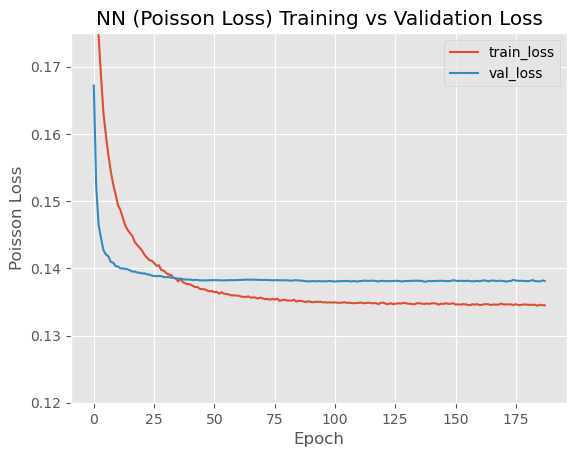

In [ ]:
# Plot loss vs. epochs (Poisson Loss)
plt.figure()
plt.plot(history_poisson.history['loss'], label='train_loss')
plt.plot(history_poisson.history['val_loss'], label='val_loss')
plt.title('NN (Poisson Loss) Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.legend()
plt.ylim(0.12, 0.175)
plt.show()

### 4.5 Compare Results of different models

In [ ]:
# Neural Network Predictions (MSE Loss)
y_pred_nn_mse_train = nn_benchmark.predict(X_train_nn).flatten()
y_pred_nn_mse_test = nn_benchmark.predict(X_test_nn).flatten()

# Neural Network Predictions (Poisson Loss)
y_pred_nn_poisson_train = nn_poisson.predict(X_train_nn).flatten()
y_pred_nn_poisson_test = nn_poisson.predict(X_test_nn).flatten()

# Neural Network metrics (MSE Loss)
mae_nn_mse_train = weighted_mae(y_train, y_pred_nn_mse_train, w_train)
mse_nn_mse_train = weighted_mse(y_train, y_pred_nn_mse_train, w_train)
mae_nn_mse_test  = weighted_mae(y_test, y_pred_nn_mse_test, w_test)
mse_nn_mse_test  = weighted_mse(y_test, y_pred_nn_mse_test, w_test)
deviance_nn_mse_train = poisson_deviance(y_train, y_pred_nn_mse_train, w_train)
deviance_nn_mse_test  = poisson_deviance(y_test,  y_pred_nn_mse_test,  w_test)

# Neural Network metrics (Poisson Loss)
mae_nn_poisson_train = weighted_mae(y_train, y_pred_nn_poisson_train, w_train)
mse_nn_poisson_train = weighted_mse(y_train, y_pred_nn_poisson_train, w_train)
mae_nn_poisson_test  = weighted_mae(y_test, y_pred_nn_poisson_test, w_test)
mse_nn_poisson_test  = weighted_mse(y_test, y_pred_nn_poisson_test, w_test)
deviance_nn_poisson_train = poisson_deviance(y_train, y_pred_nn_poisson_train, w_train)
deviance_nn_poisson_test  = poisson_deviance(y_test,  y_pred_nn_poisson_test,  w_test)

# Comparison DataFrame including Poisson NN
df_compare_poisson = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [round(mae_train, 4), round(mse_train, 4), round(deviance_train, 4)],
    'GLM Test':    [round(mae_test, 4), round(mse_test, 4), round(deviance_test, 4)],
    'GLM+Int Train': [round(mae_int_train, 4), round(mse_int_train, 4), round(deviance_int_train, 4)],
    'GLM+Int Test':  [round(mae_int_test, 4), round(mse_int_test, 4), round(deviance_int_test, 4)],
    'FNN MSE Train': [round(mae_nn_mse_train,4), round(mse_nn_mse_train,4), round(deviance_nn_mse_train,4)],
    'FNN MSE Test':  [round(mae_nn_mse_test,4), round(mse_nn_mse_test,4), round(deviance_nn_mse_test,4)],
    'FNN Poisson Train': [round(mae_nn_poisson_train,4),  round(mse_nn_poisson_train,4), round(deviance_nn_poisson_train,4)],
    'FNN Poisson Test':  [round(mae_nn_poisson_test,4), round(mse_nn_poisson_test,4), round(deviance_nn_poisson_test,4)],
})
df_compare_poisson.T

19069/19069 ━━━━━━━━━━━━━━━━━━━━ 12s 599us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step
19069/19069 ━━━━━━━━━━━━━━━━━━━━ 8s 435us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.1376,0.2332,0.4559
GLM Test,0.1395,0.2734,0.4671
GLM+Int Train,0.1375,0.2332,0.4555
GLM+Int Test,0.1394,0.2734,0.4665
FNN MSE Train,0.6768,0.6139,1.3435
FNN MSE Test,0.6786,0.654,1.3481
FNN Poisson Train,0.1359,0.2331,0.4529
FNN Poisson Test,0.1376,0.2733,0.4645


## 5. Regularization Techniques: L2-Regularization



### 5.1 Regularization L-2 for Poisson GLM with interactions

In [ ]:
# Define a pipeline with preprocessing and Poisson GLM with interaction terms
glm_l2 = Pipeline(steps=[
    ('pre', preprocessor_int),
    ('glm', PoissonRegressor(max_iter=1000))
])

# Define grid of alpha values for L2 regularization
param_grid = {
    'glm__alpha': np.logspace(-6, 1, 16)  # from 1e-6 to 10
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(glm_l2, param_grid, cv=5, scoring='neg_mean_poisson_deviance', n_jobs=-1)
grid_search.fit(X_train_int, y_train, glm__sample_weight=w_train)

# Save the best alpha parameter
best_alpha = grid_search.best_params_['glm__alpha']
print(f"Best alpha (L2 regularization): {best_alpha}")

# Train GLM model with best alpha
glm_l2_final = grid_search.best_estimator_

y_pred_l2_train = glm_l2_final.predict(X_train_int)
y_pred_l2_test = glm_l2_final.predict(X_test_int)

In [ ]:
print(f"Best alpha (L2 regularization): {best_alpha}")

Best alpha (L2 regularization): 0.0054116952654646375


In [ ]:
# Evaluate metrics on new GLM with L2 regularization
mae_l2_train = weighted_mae(y_train, y_pred_l2_train, w_train)
mse_l2_train = weighted_mse(y_train, y_pred_l2_train, w_train)
deviance_l2_train = poisson_deviance(y_train, y_pred_l2_train, w_train)
mae_l2_test = weighted_mae(y_test, y_pred_l2_test, w_test)
mse_l2_test = weighted_mse(y_test, y_pred_l2_test, w_test)
deviance_l2_test = poisson_deviance(y_test, y_pred_l2_test, w_test)

# Comparison DataFrame including L2-regularized GLM
df_compare_l2 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [round(mae_train, 4), round(mse_train, 4), round(deviance_train, 4)],
    'GLM Test':    [round(mae_test, 4), round(mse_test, 4), round(deviance_test, 4)],
    'GLM+Int Train': [round(mae_int_train, 4), round(mse_int_train, 4), round(deviance_int_train, 4)],
    'GLM+Int Test':  [round(mae_int_test, 4), round(mse_int_test, 4), round(deviance_int_test, 4)],
    'FNN MSE Train': [round(mae_nn_mse_train,4), round(mse_nn_mse_train,4), round(deviance_nn_mse_train,4)],
    'FNN MSE Test':  [round(mae_nn_mse_test,4), round(mse_nn_mse_test,4), round(deviance_nn_mse_test,4)],
    'FNN Poisson Train': [round(mae_nn_poisson_train,4),  round(mse_nn_poisson_train,4), round(deviance_nn_poisson_train,4)],
    'FNN Poisson Test':  [round(mae_nn_poisson_test,4), round(mse_nn_poisson_test,4), round(deviance_nn_poisson_test,4)],
    'GLM L2 Train': [round(mae_l2_train,4), round(mse_l2_train,4), round(deviance_l2_train,4)],
    'GLM L2 Test':  [round(mae_l2_test,4), round(mse_l2_test,4), round(deviance_l2_test,4)],
})
df_compare_l2.T

,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.1376,0.2332,0.4559
GLM Test,0.1395,0.2734,0.4671
GLM+Int Train,0.1375,0.2332,0.4555
GLM+Int Test,0.1394,0.2734,0.4665
FNN MSE Train,0.6768,0.6139,1.3435
FNN MSE Test,0.6786,0.654,1.3481
FNN Poisson Train,0.1359,0.2331,0.4529
FNN Poisson Test,0.1376,0.2733,0.4645
GLM L2 Train,0.1378,0.2333,0.4565


### 5.2 FNN Poisson with L2-Regularization (without tuner)

We apply L2-regularization to the previously optimized Poisson neural network architecture to reduce overfitting. We use the previously found optimal hyperparameters and add L2 regularization to the Dense layers.

In [ ]:
# Retrieve the best hyperparameters from the Poisson FNN model
tuned_lr = best_hp_poisson.get('learning_rate')
tuned_B = best_hp_poisson.get('batch_size')
tuned_depth = best_hp_poisson.get('num_layers')
tuned_width = [best_hp_poisson.get(f'units_layer_{i}') for i in range(tuned_depth)]
tuned_dropout_rate = best_hp_poisson.get('dropout_rate')

[25, 20]


In [ ]:
# Set L2 regularization parameter in the best Poisson FNN model
def build_poisson_model(input_shape, lr, width, dropout_rate, l2):
    """
    Build a Keras Sequential model for regression with Poisson loss.
    Params:
    ----------
        input_shape : Number of input features.
        lr : Learning rate.
        width : List containing the number of units in each hidden layer.
        dropout_rate : Dropout rate for regularization.
        l2 : L2 regularization parameter for the Dense layers.
    Returns:
    ----------
        model : Compiled Keras model ready for training.
    """
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(input_shape,)))

    # Tune the number of layers
    for i in width: # number of hidden layers
        model.add(keras.layers.Dense(
            units=i,
            activation=None, # activation function set to none to perform batch normalization
            bias_initializer='zeros',
            kernel_initializer="he_normal",
            kernel_regularizer=keras.regularizers.l2(l2)))
        model.add(keras.layers.BatchNormalization()) # batch normalization after each Dense layer
        model.add(keras.layers.ReLU())
    # Output layer
        model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(1, activation='exponential'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.Poisson()
    )
    return model


In [ ]:
# Parameters to be searched for L2 regularization in a manual grid search
l2_grid = np.logspace(-6, 1, 10) # Same range as the one used in the GLM with L2 regularization

# K-Fold cross-validation setup for L2 regularization
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_l2 = None
best_score = float('inf')

for l2_val in l2_grid:
    val_losses = []

    X_np = np.array(X_train_nn)
    y_np = np.array(y_train)
    w_np = np.array(w_train)

    for train_idx, val_idx in kf.split(X_train_nn):
        X_tr, X_val = X_np[train_idx], X_np[val_idx]
        y_tr, y_val = y_np[train_idx], y_np[val_idx]
        w_tr, w_val = w_np[train_idx], w_np[val_idx]

        model = build_poisson_model(input_shape=X_train_nn.shape[1], l2=l2_val, lr=tuned_lr, width=tuned_width, dropout_rate=tuned_dropout_rate)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        model.fit(
            X_tr, y_tr,
            sample_weight=w_tr,
            validation_data=(X_val, y_val, w_val),
            epochs=100,
            batch_size=tuned_B,
            callbacks=[early_stopping]
        )

        val_loss = model.evaluate(X_val, y_val, sample_weight=w_val, verbose=0)
        val_losses.append(val_loss)

    avg_val_loss = np.mean(val_losses)
    print(f"L2: {l2_val:.1e}, Mean Validation Loss: {avg_val_loss:.5f}")

    if avg_val_loss < best_score:
        best_score = avg_val_loss
        best_l2 = l2_val

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.1073 - val_loss: 0.1986
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3998 - val_loss: 0.1882
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3033 - val_loss: 0.1753
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2560 - val_loss: 0.1607
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2316 - val_loss: 0.1495
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2150 - val_loss: 0.1428
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2053 - val_loss: 0.1397
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1988 - val_loss: 0.1381
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1942 - val_loss: 0.1371
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1897 - val_loss: 0.1367
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1842 - val_loss: 0.1363
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

In [ ]:
print(f"\nBest L2 regularization value: {best_l2}")


Best L2 regularization value: 1e-06


In [ ]:
# Train the Poisson FNN model with early stopping and the best L2 regularization value (early stopping added to avoid overfitting)
poisson_fnn_l2 = build_poisson_model(input_shape=X_train_nn.shape[1], l2=best_l2, lr=tuned_lr, width=tuned_width, dropout_rate=tuned_dropout_rate)

early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

history_poisson_l2 = poisson_fnn_l2.fit(
            X_tr, y_tr,
            sample_weight=w_tr,
            validation_data=(X_val, y_val, w_val),
            epochs=100,
            batch_size=tuned_B,
            verbose=1,
            callbacks=[early_stopping]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7590 - val_loss: 0.2143
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2703 - val_loss: 0.1803
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2025 - val_loss: 0.1538
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1835 - val_loss: 0.1439
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1764 - val_loss: 0.1411
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1713 - val_loss: 0.1402
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1692 - val_loss: 0.1400
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1647 - val_loss: 0.1398
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1630 - val_loss: 0.1396
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1618 - val_loss: 0.1396
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1594 - val_loss: 0.1396
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Epoch 1/500
37/37 - 3s - 68ms/step - loss: 0.5867 - val_loss: 0.2459
Epoch 2/500
37/37 - 1s - 15ms/step - loss: 0.1819 - val_loss: 0.1838
Epoch 3/500
37/37 - 1s - 16ms/step - loss: 0.1568 - val_loss: 0.1748
Epoch 4/500
37/37 - 1s - 14ms/step - loss: 0.1538 - val_loss: 0.1661
Epoch 5/500
37/37 - 1s - 15ms/step - loss: 0.1522 - val_loss: 0.1587
Epoch 6/500
37/37 - 1s - 16ms/step - loss: 0.1508 - val_loss: 0.1533
Epoch 7/500
37/37 - 1s - 18ms/step - loss: 0.1499 - val_loss: 0.1496
Epoch 8/500
37/37 - 1s - 19ms/step - loss: 0.1479 - val_loss: 0.1467
Epoch 9/500
37/37 - 0s - 12ms/step - loss: 0.1473 - val_loss: 0.1455
Epoch 10/500
37/37 - 0s - 13ms/step - loss: 0.1465 - val_loss: 0.1448
Epoch 11/500
37/37 - 1s - 14ms/step - loss: 0.1456 - val_loss: 0.1434
Epoch 12/500
37/37 - 1s - 15ms/step - loss: 0.1445 - val_loss: 0.1427
Epoch 13/500
37/37 - 0s - 13ms/step - loss: 0.1436 - val_loss: 0.1430
Epoch 14/500
37/37 - 0s - 13ms/step - loss: 0.1431 - val_loss: 0.1420
Epoch 15/500
37/37 - 1s - 14m

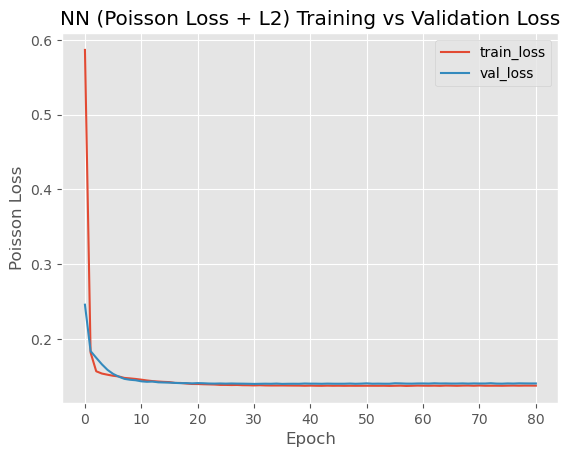

In [ ]:
# Plot loss vs. epochs (Poisson Loss with L2)
plt.figure()
plt.plot(history_poisson_l2.history['loss'], label='train_loss')
plt.plot(history_poisson_l2.history['val_loss'], label='val_loss')
plt.title('NN (Poisson Loss + L2) Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Poisson Loss')
plt.legend()
plt.show()

In [ ]:
# Predictions of new architecture with L2 regularization
y_pred_nn_poisson_l2_train = poisson_fnn_l2.predict(X_train_nn).flatten()
y_pred_nn_poisson_l2_test = poisson_fnn_l2.predict(X_test_nn).flatten()

# Evaluate metrics
mae_nn_poisson_l2_train = weighted_mae(y_train, y_pred_nn_poisson_l2_train, w_train)
mse_nn_poisson_l2_train = weighted_mse(y_train, y_pred_nn_poisson_l2_train, w_train)
deviance_nn_poisson_l2_train = poisson_deviance(y_train, y_pred_nn_poisson_l2_train, w_train)
mae_nn_poisson_l2_test = weighted_mae(y_test, y_pred_nn_poisson_l2_test, w_test)
mse_nn_poisson_l2_test = weighted_mse(y_test, y_pred_nn_poisson_l2_test, w_test)
deviance_nn_poisson_l2_test = poisson_deviance(y_test, y_pred_nn_poisson_l2_test, w_test)

# Comparison DataFrame including NN with L2 regularization
df_compare_nn_poisson_l2 = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'Poisson Deviance'],
    'GLM Train':   [round(mae_train, 4), round(mse_train, 4), round(deviance_train, 4)],
    'GLM Test':    [round(mae_test, 4), round(mse_test, 4), round(deviance_test, 4)],
    'GLM+Int Train': [round(mae_int_train, 4), round(mse_int_train, 4), round(deviance_int_train, 4)],
    'GLM+Int Test':  [round(mae_int_test, 4), round(mse_int_test, 4), round(deviance_int_test, 4)],
    'FNN MSE Train': [round(mae_nn_mse_train,4), round(mse_nn_mse_train,4), round(deviance_nn_mse_train,4)],
    'FNN MSE Test':  [round(mae_nn_mse_test,4), round(mse_nn_mse_test,4), round(deviance_nn_mse_test,4)],
    'FNN Poisson Train': [round(mae_nn_poisson_train,4),  round(mse_nn_poisson_train,4), round(deviance_nn_poisson_train,4)],
    'FNN Poisson Test':  [round(mae_nn_poisson_test,4), round(mse_nn_poisson_test,4), round(deviance_nn_poisson_test,4)],
    'GLM L2 Train': [round(mae_l2_train,4), round(mse_l2_train,4), round(deviance_l2_train,4)],
    'GLM L2 Test':  [round(mae_l2_test,4), round(mse_l2_test,4), round(deviance_l2_test,4)],
    'NN Poisson L2 Train': [round(mae_nn_poisson_l2_train,4), round(mse_nn_poisson_l2_train,4), round(deviance_nn_poisson_l2_train,4)],
    'NN Poisson L2 Test':  [round(mae_nn_poisson_l2_test,4), round(mse_nn_poisson_l2_test,4), round(deviance_nn_poisson_l2_test,4)],
})
df_compare_nn_poisson_l2.T

19069/19069 ━━━━━━━━━━━━━━━━━━━━ 9s 462us/step
2119/2119 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step


,0,1,2
Metric,MAE,MSE,Poisson Deviance
GLM Train,0.1376,0.2332,0.4559
GLM Test,0.1395,0.2734,0.4671
GLM+Int Train,0.1375,0.2332,0.4555
GLM+Int Test,0.1394,0.2734,0.4665
FNN MSE Train,0.6768,0.6139,1.3435
FNN MSE Test,0.6786,0.654,1.3481
FNN Poisson Train,0.1359,0.2331,0.4529
FNN Poisson Test,0.1376,0.2733,0.4645
GLM L2 Train,0.1378,0.2333,0.4565


## 6. Additional plots to visually assess the goodness of our predictions

In [ ]:
def plot_obs_pred(data, x, y_obs, y_pred, weight, y_label, title, ax):
    """
    Plot observed vs predicted frequencies, weighted by exposure.
    Params:
        data : DataFrame containing the data to plot.
        x : Column name for the x-axis (categorical or continuous).
        y_obs : Column name for observed frequencies.
        y_pred : Column name for predicted frequencies.
        weight : Column name for weights (exposure).
        y_label : Label for the y-axis.
        title : Title of the plot.
        ax : Matplotlib Axes object to plot on.
    """

    # Group by x and compute weighted means
    grouped = data.groupby(x).apply(
        lambda g: pd.Series({
            'Observed': np.average(g[y_obs], weights=g[weight]),
            'Predicted': np.average(g[y_pred], weights=g[weight]),
            'Exposure': g[weight].sum()
        })
    ).reset_index()

    ax.plot(grouped[x], grouped['Observed'], marker='o', label='Observed')
    ax.plot(grouped[x], grouped['Predicted'], marker='o', label='Predicted')

    ax.set_xlabel(x)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
    if grouped[x].dtype.name == 'category' or grouped[x].dtype == object:
        ax.tick_params(axis='x', rotation=45)


### 6.1 GLM plots

In [ ]:
df_plot = df.copy()
df_plot['Freq_Observed'] = df_plot['ClaimNb'] / df_plot['Exposure']
df_plot['Freq_Predicted'] = glm.predict(X)

# Get train and test indices from the split
train_idx = X_train.index
test_idx = X_test.index

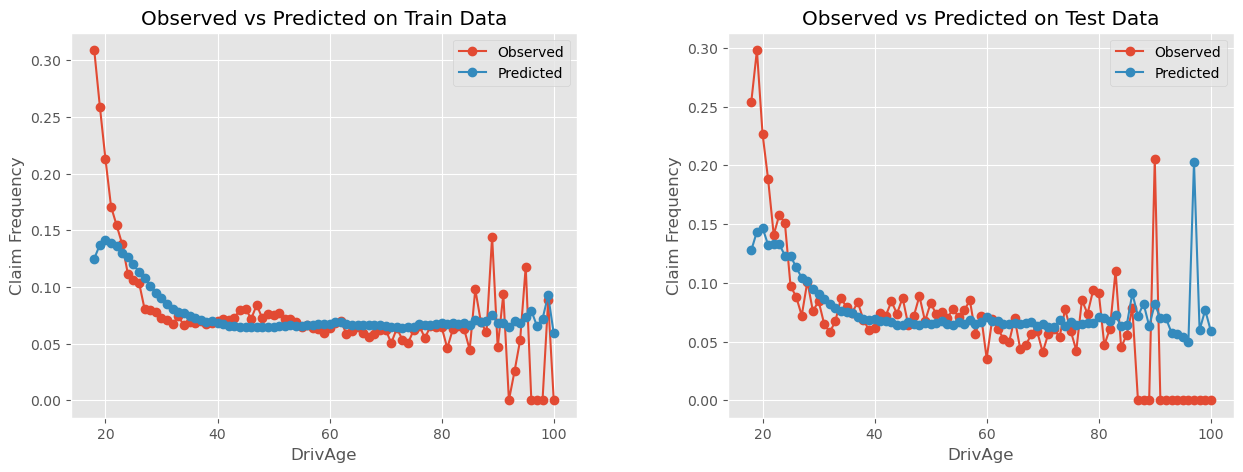

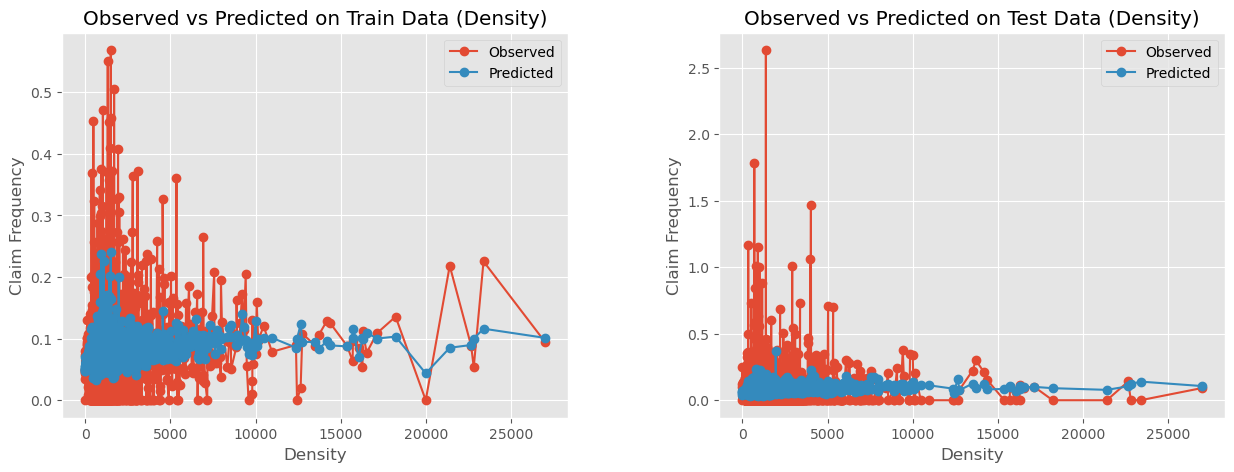

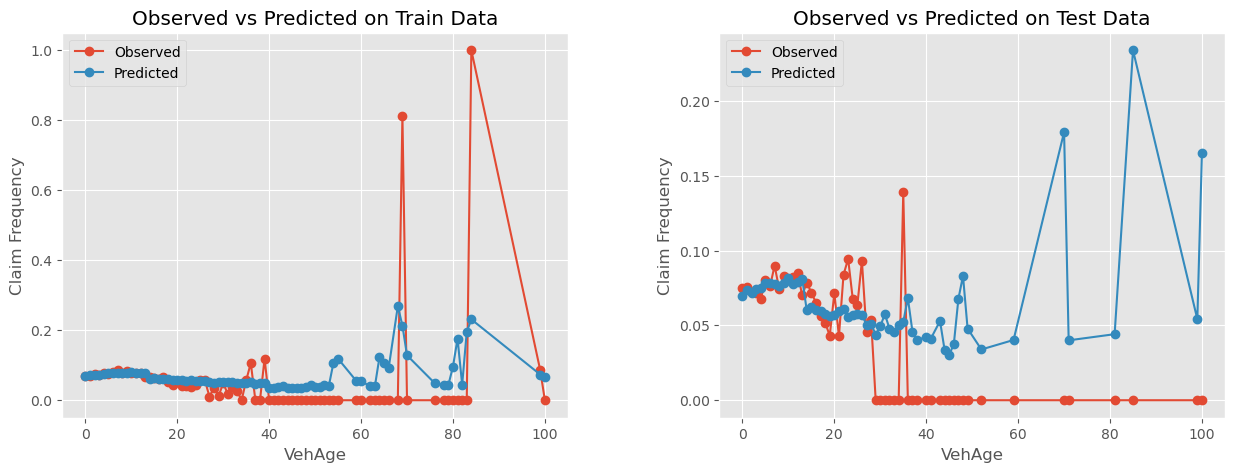

In [ ]:
# Plot DrivAge vs (predicted and true value) Frequency
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[train_idx], 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data', ax=axes[0])
plot_obs_pred(df_plot.loc[test_idx], 'DrivAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data', ax=axes[1])
plt.show()

# Plot Density vs (predicted and true value) Frequency
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[train_idx], 'Density', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data (Density)', ax=axes[0])
plot_obs_pred(df_plot.loc[test_idx], 'Density', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data (Density)', ax=axes[1])
plt.show()

# Plot VehAge vs (predicted and true value) Frequency
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[train_idx], 'VehAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Train Data', ax=axes[0])
plot_obs_pred(df_plot.loc[test_idx], 'VehAge', 'Freq_Observed', 'Freq_Predicted', 'Exposure',
              y_label='Claim Frequency', title='Observed vs Predicted on Test Data', ax=axes[1])
plt.show()

### 6.2 Poisson FNN+L2 plots

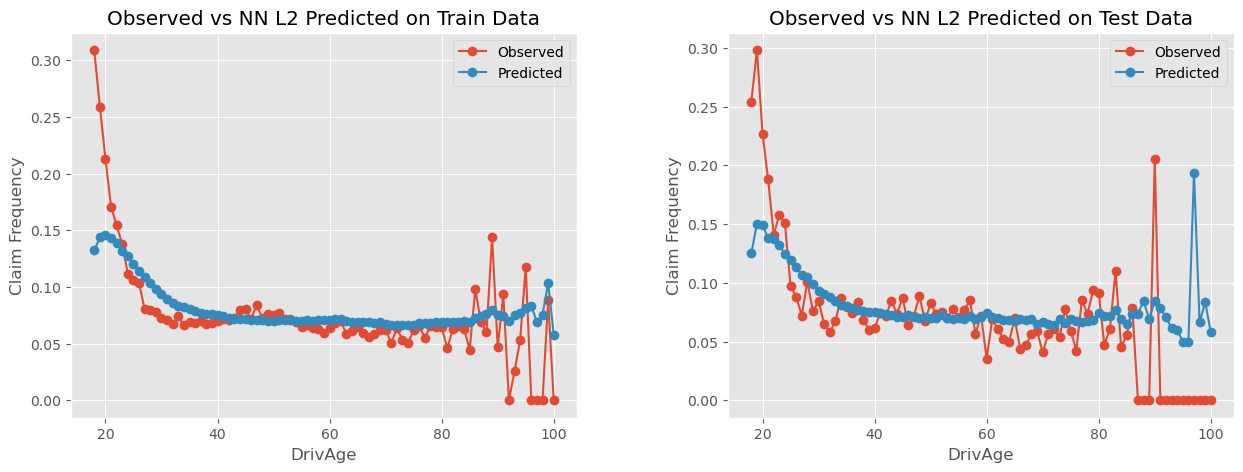

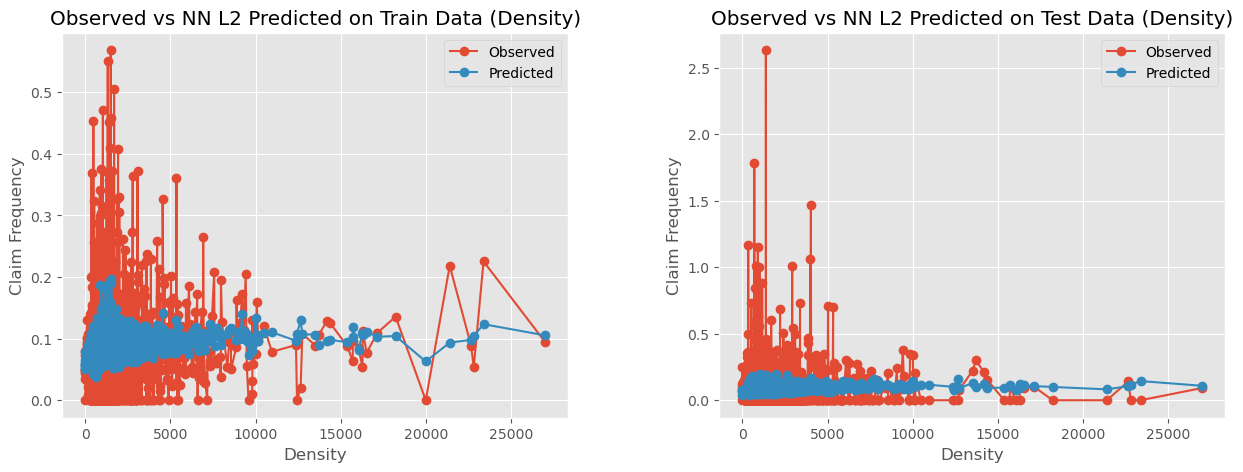

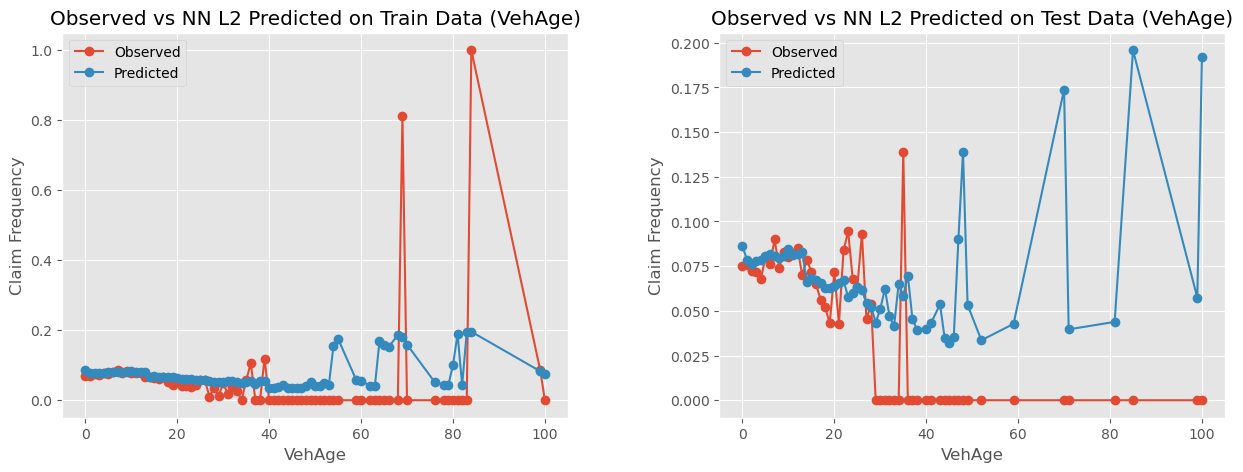

In [ ]:
# Poisson L2 predictions to df_plot
df_plot['Freq_Predicted_NN_L2'] = np.nan
df_plot.loc[train_idx, 'Freq_Predicted_NN_L2'] = y_pred_nn_poisson_l2_train
df_plot.loc[test_idx, 'Freq_Predicted_NN_L2'] = y_pred_nn_poisson_l2_test

# Plot DrivAge vs (predicted and true value) Frequency
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[train_idx], 'DrivAge', 'Freq_Observed', 'Freq_Predicted_NN_L2', 'Exposure',
              y_label='Claim Frequency', title='Observed vs NN L2 Predicted on Train Data', ax=axes[0])
plot_obs_pred(df_plot.loc[test_idx], 'DrivAge', 'Freq_Observed', 'Freq_Predicted_NN_L2', 'Exposure',
              y_label='Claim Frequency', title='Observed vs NN L2 Predicted on Test Data', ax=axes[1])
plt.show()

# Plot Density vs (predicted and true value) Frequency
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[train_idx], 'Density', 'Freq_Observed', 'Freq_Predicted_NN_L2', 'Exposure',
              y_label='Claim Frequency', title='Observed vs NN L2 Predicted on Train Data (Density)', ax=axes[0])
plot_obs_pred(df_plot.loc[test_idx], 'Density', 'Freq_Observed', 'Freq_Predicted_NN_L2', 'Exposure',
              y_label='Claim Frequency', title='Observed vs NN L2 Predicted on Test Data (Density)', ax=axes[1])
plt.show()

# Plot VehAge vs (predicted and true value) Frequency
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
plot_obs_pred(df_plot.loc[train_idx], 'VehAge', 'Freq_Observed', 'Freq_Predicted_NN_L2', 'Exposure',
              y_label='Claim Frequency', title='Observed vs NN L2 Predicted on Train Data (VehAge)', ax=axes[0])
plot_obs_pred(df_plot.loc[test_idx], 'VehAge', 'Freq_Observed', 'Freq_Predicted_NN_L2', 'Exposure',
              y_label='Claim Frequency', title='Observed vs NN L2 Predicted on Test Data (VehAge)', ax=axes[1])
plt.show()